In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import sklearn.metrics as skm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
os.chdir('/content/drive/MyDrive/Electrical Load Forecasting/')
df = pd.read_csv('/content/drive/MyDrive/Electrical Load Forecasting/household_power_consumption.csv',header=0,infer_datetime_format=True,parse_dates=['datetime'],index_col=['datetime'])
daily_grp = df.resample('D') #This allows data to be grouped by day.
df_daily = daily_grp.sum() # Sum of all observations for each day
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933333
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666667
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433333
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900000
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800000


In [ ]:
# Evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual,predicted):
  # Daily scores
  scores = []
  for i in range(actual.shape[1]):
    mse = skm.mean_squared_error(actual[:,i],predicted[:,i])
    rmse = math.sqrt(mse)
    scores.append(rmse)
  # Overall score
  s=0
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s += (actual[row,col]-predicted[row,col])**2
  score = math.sqrt(s/(actual.shape[0]*actual.shape[1]))
  # Returns overall RMSE and array of daily RMSE
  return score,scores

# Split dataset into test and train
def split_dataset(data):
  train,test = data[1:-328],data[-328:-6] #322 days = 46 weeks
  train = np.array(np.split(train,len(train)//7))
  test = np.array(np.split(test,len(test)//7))
  return train,test
train,test = split_dataset(df_daily.values)

# Summarize scores
def summarize_scores(name,score,scores):
  s_scores = ', '.join(['%.1f'% s for s in scores])
  print('%s: [%.3f] %s' % (name,score,s_scores))

In [ ]:
# Comvert history into inputs and outputs
def to_supervised(train,n_input,n_out=7):
    data = train.reshape((train.shape[0]*train.shape[1],train.shape[2]))
    X,y = [],[]
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            x_input = data[in_start:in_end,0]
            x_input = x_input.reshape((len(x_input),1))
            X.append(x_input)
            y.append(data[in_end:out_end,0])
        in_start += 1
    return np.array(X),np.array(y)

# train the model
def build_model(train,n_input):
    train_x,train_y = to_supervised(train,n_input)
    verbose,epochs,batch_size = 0,20,4
    n_timesteps, n_features, n_outputs = train_x.shape[1],train_x.shape[2],train_y.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10,activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse',optimizer='adam')
    model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,verbose=verbose)
    return model

# make a forecast
def forecast(model,history,n_input):
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2]))
    input_x = data[-n_input:,0]
    input_x = input_x.reshape((1,len(input_x),1))
    yhat = model.predict(input_x,verbose=0)
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    model = build_model(train,n_input)
    history = [x for x in train]
	# walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

Convolutional Neural Network models, or CNNs for short, are a type of deep neural network that was developed for use with image data, such as handwriting recognition. They are proven very effective on challenging computer vision problems when trained at scale for tasks such as identifying and localizing objects in images and automatically describing the content of images.

They are a model that are comprised of two main types of elements: convolutional layers and pooling layers.
* Convolutional layers read an input, such as a 2D image or a 1D signal using a kernel that reads in small segments at a time and steps across the entire input field. Each read results in an interpretation of the input that is projected onto a filter map and represents an interpretation of the input.
* Pooling layers take the feature map projections and distill them to the most essential elements, such as using a signal averaging or signal maximizing process.

The convolution and pooling layers can be repeated at depth, providing multiple layers of abstraction of the input signals.

The output of these networks is often one or more fully-connected layers that interpret what has been read and maps this internal representation to a class value.

The convolutional layers can read sequences of input data and automatically extract features.
The pooling layers can distill the extracted features and focus attention on the most salient elements. The fully connected layers can interpret the internal representation and output a vector representing multiple time steps. The key benefits of the approach are the automatic feature learning and the ability of the model to output a multi-step vector directly.

CNNs can be used in either a recursive or direct forecast strategy, where the model makes one-step predictions and outputs are fed as inputs for subsequent predictions, and where one model is developed for each time step to be predicted. Alternately, CNNs can be used to predict the entire output sequence as a one-step prediction of the entire vector. This is a general benefit of feed-forward neural networks.

An important secondary benefit of using CNNs is that they can support multiple 1D inputs in order to make a prediction. This is useful if the multi-step output sequence is a function of more than one input sequence. This can be achieved using two different model configurations.
* Multiple Input Channels. This is where each input sequence is read as a separate channel, like the different channels of an image (e.g. red, green and blue).
* Multiple Input Heads. This is where each input sequence is read by a different CNN sub-model and the internal representations are combined before being interpreted and used to make a prediction.

We will develop different types of CNN models for multi-step time series forecasting:
* A CNN for multi-step time series forecasting with univariate input data.
* A CNN for multi-step time series forecasting with multivariate input data via channels.



# Univariate CNN 

cnn: [385.809] 401.5, 395.0, 358.0, 377.0, 380.9, 317.4, 456.8


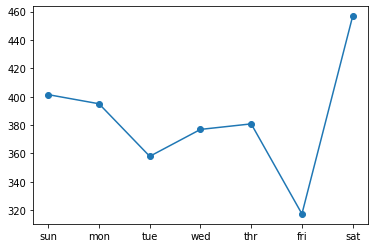

In [ ]:
train,test = split_dataset(df_daily.values)
n_input = 14
score,scores = evaluate_model(train,test,n_input)
summarize_scores('cnn',score,scores)
days = ['sun','mon','tue','wed','thr','fri','sat']
plt.plot(days,scores,marker='o',label='cnn')
plt.show()

# Multichannel CNN

In [ ]:
# Comvert history into inputs and outputs
def to_supervised(train,n_input,n_out=7):
    data = train.reshape((train.shape[0]*train.shape[1],train.shape[2]))
    X,y = [],[]
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            X.append(data[in_start:in_end,:])
            y.append(data[in_end:out_end,0])
        in_start += 1
    return np.array(X),np.array(y)

# train the model
def build_model(train,n_input):
    train_x,train_y = to_supervised(train,n_input)
    verbose,epochs,batch_size = 0,70,16
    n_timesteps, n_features, n_outputs = train_x.shape[1],train_x.shape[2],train_y.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100,activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse',optimizer='adam')
    model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,verbose=verbose)
    return model

# make a forecast
def forecast(model,history,n_input):
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2]))
    input_x = data[-n_input:,:]
    input_x = input_x.reshape((1,input_x.shape[0],input_x.shape[1]))
    yhat = model.predict(input_x,verbose=0)
    yhat = yhat[0]
    return yhat

cnn: [418.466] 435.5, 386.9, 360.4, 456.3, 394.3, 327.5, 534.4


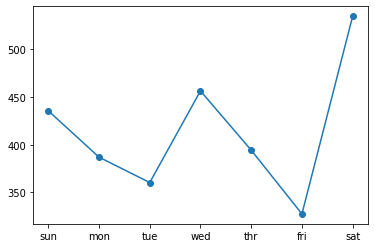

In [ ]:
train,test = split_dataset(df_daily.values)
n_input = 14
score,scores = evaluate_model(train,test,n_input)
summarize_scores('cnn',score,scores)
days = ['sun','mon','tue','wed','thr','fri','sat']
plt.plot(days,scores,marker='o',label='cnn')
plt.show()